# Task 1 (30 points): Decision Tree Classifier  
Implement a Decision Tree Classifier for your classification problem. You may use a built-in package to implement your classifier. Try modifying one or more of the input parameters and describe what changes you notice in your results. Clearly describe how these factors are affecting your output.

## Problem

My problem is going to be classifying which heuristics are fastest able to find a proof of a conjecture in first order logic based on statistical and dynamic information about the syntax of the premisses and conjecture. I.E. we will be creating a classifier to aid in the heuristic selection problem for automated theorem proving. 

## Dataset & Parsing

For my dataset I will be using the First Order Theorem Proving dataset provided by Bridge et al. at [https://archive.ics.uci.edu/ml/datasets/First-order+theorem+proving](https://archive.ics.uci.edu/ml/datasets/First-order+theorem+proving) and explained in the paper [Machine Learning for First-Order Theorem Proving](https://www.semanticscholar.org/paper/Machine-Learning-for-First-Order-Theorem-Proving-to-Bridge-Holden/19169c6de54bfb3b06a6a16e593cdf7ac1391209). 

In [60]:

#Imports
import pandas as pd
import numpy as np

#The feature list can be found in Tables 2 and 3 in the paper, 
#the first 14 are statistical features, the remaining are dynamic features
feature_names = [f"x_{i}" for i in range(51)]

#H1-H5 respectively correspond to heuristics 1-5 in the paper in Table 1.
heuristic_names = [f"H{x}" for x in range(1,6)]

#The final column indicates if a proof was found at all within reasonable time,
# we treat this as the 6th heuristic, H0
col_names = feature_names + heuristic_names + ["H0"] 

#The data is provided to us pre-split into train, test, and validation. 
#Since we will be doing k-fold validation later, we recombine it into a single dataframe. 
train_raw = pd.read_csv("./ml-prove/train.csv", names=col_names)
test_raw = pd.read_csv("./ml-prove/test.csv", names=col_names)
valid_raw = pd.read_csv("./ml-prove/validation.csv", names=col_names)
data_raw = pd.concat([train_raw, test_raw, valid_raw])
print(data_raw.shape)
data_raw.head()

(6118, 57)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_47,x_48,x_49,x_50,H1,H2,H3,H4,H5,H0
0,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4630,0.27015,-1.5559,-1,-1,-1,-1,-1,1
1,1.4895,0.81688,2.1168,1.7895,1.5403,-0.31850,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4801,0.21361,-1.5559,1,-1,-1,-1,-1,-1
2,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4744,0.23245,-1.5559,-1,-1,-1,-1,-1,1
3,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4401,0.34553,-1.5559,-1,-1,-1,-1,-1,1
4,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,-0.48278,1.4458,0.32669,-1.5559,-1,-1,-1,-1,-1,1


In [64]:
#Buckets the heuristics into a single class col with the heuristic label

from configparser import InterpolationSyntaxError


raw_copy = data_raw.copy()
heuristics = [f"H{i}" for i in range(6)]
for i,h in enumerate(heuristics):
    raw_copy[h] = (raw_copy[h] == 1).astype(int) * raw_copy[h] * i
raw_copy["H"] = raw_copy[heuristics].sum(axis=1)
raw_copy.drop(heuristics, axis=1, inplace=True)
data = raw_copy
data.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,H
0,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6803,-0.48278,1.4630,0.27015,-1.5559,0
1,1.4895,0.81688,2.1168,1.7895,1.5403,-0.31850,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6974,-0.48278,1.4801,0.21361,-1.5559,1
2,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6917,-0.48278,1.4744,0.23245,-1.5559,0
3,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6575,-0.48278,1.4401,0.34553,-1.5559,0
4,1.4895,0.81688,2.1168,1.7836,1.5346,-0.30543,-1.2477,-0.14537,-0.59356,-0.23316,...,0.026975,1.8323,0.97743,2.6676,1.6632,-0.48278,1.4458,0.32669,-1.5559,0


## Analysis

We investigate the correlations of our features and heuristics as well as the ratios of heuristics that were found to be fastest. Our results show there is some minimal corelation between our heuristic and our

([<matplotlib.patches.Wedge at 0x164e0d46df0>,
 [Text(0.28206298923703516, 1.0632217407966547, '0'),
  Text(-1.0990950212662474, -0.04461092049876686, '1'),
  Text(-0.6091885351868704, -0.9159090176414223, '3'),
  Text(0.12905276048629033, -1.0924034900213695, '5'),
  Text(0.7536932923576143, -0.80121558962313, '4'),
  Text(1.0659230395982722, -0.27167641350249794, '2')],
 [Text(0.15385253958383732, 0.5799391313436297, '41.7%'),
  Text(-0.5995063752361349, -0.024333229362963737, '17.8%'),
  Text(-0.33228465555647474, -0.4995867368953212, '12.2%'),
  Text(0.07039241481070381, -0.5958564491025652, '10.2%'),
  Text(0.4111054321950623, -0.43702668524898, '10.1%'),
  Text(0.581412567053603, -0.14818713463772612, '7.9%')])

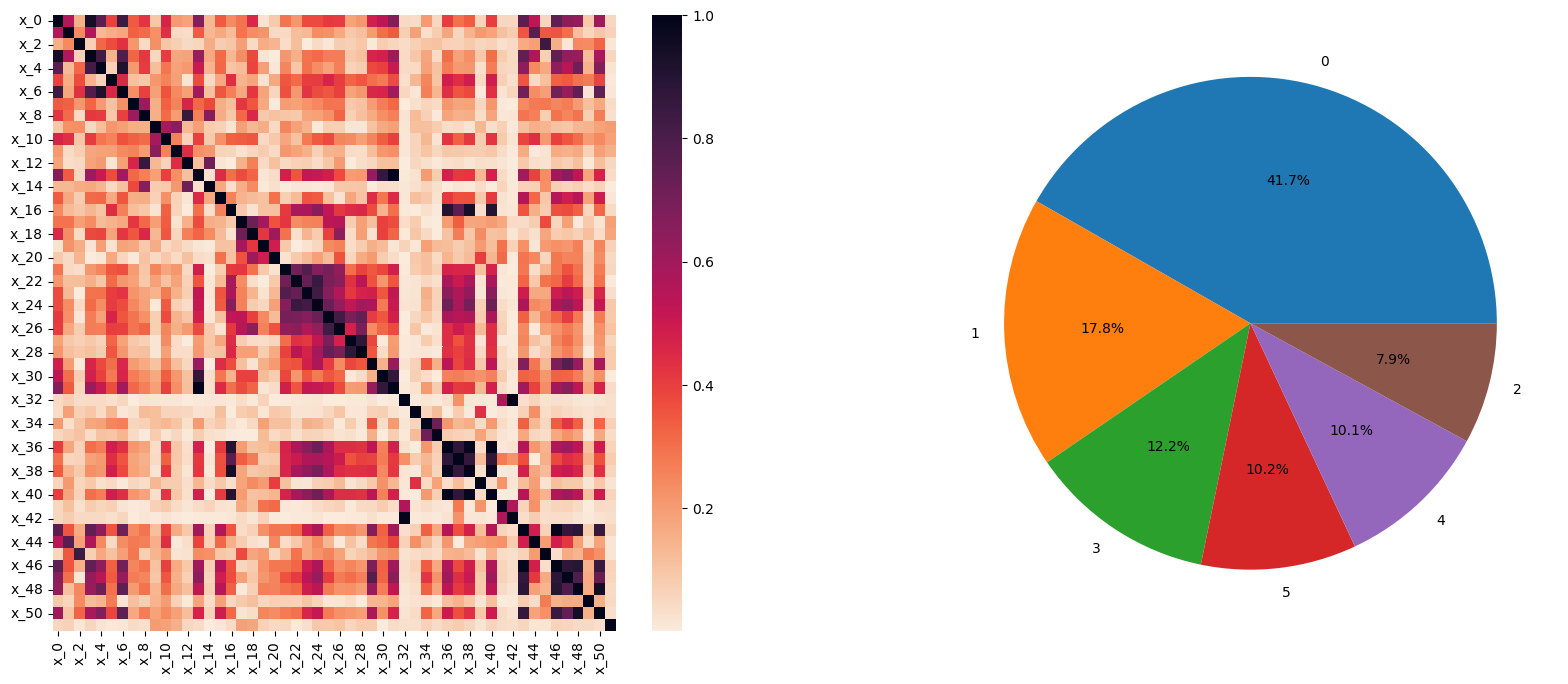

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2, figsize=(20,8))
#ax[0].imshow(data_raw.corr().abs(), cmap='rocket_r')
sns.heatmap(data.corr().abs(),annot=False, ax=ax[0], cmap='rocket_r')
ax[1].pie(x=data["H"].value_counts(), labels=data["H"].value_counts().index, autopct='%1.1f%%')



## Decision Tree

In [96]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.05)
model = DecisionTreeClassifier()
model.fit(train[feature_names], train["H"])
model.score(test[feature_names], test["H"])


0.6209150326797386